In [1]:
pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Новая БД


In [3]:
df = pd.read_csv("diabets_after_EDA.csv")

In [4]:
df.info()

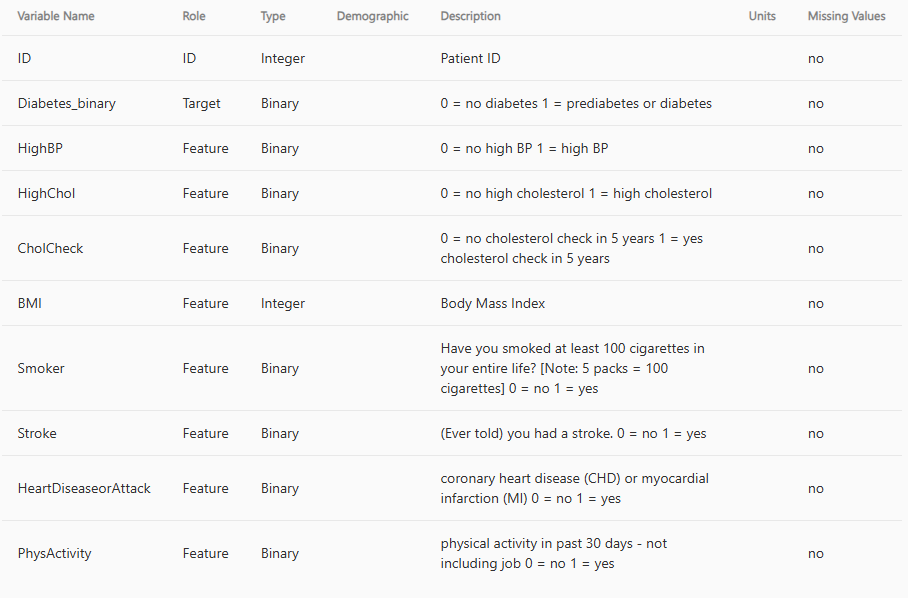

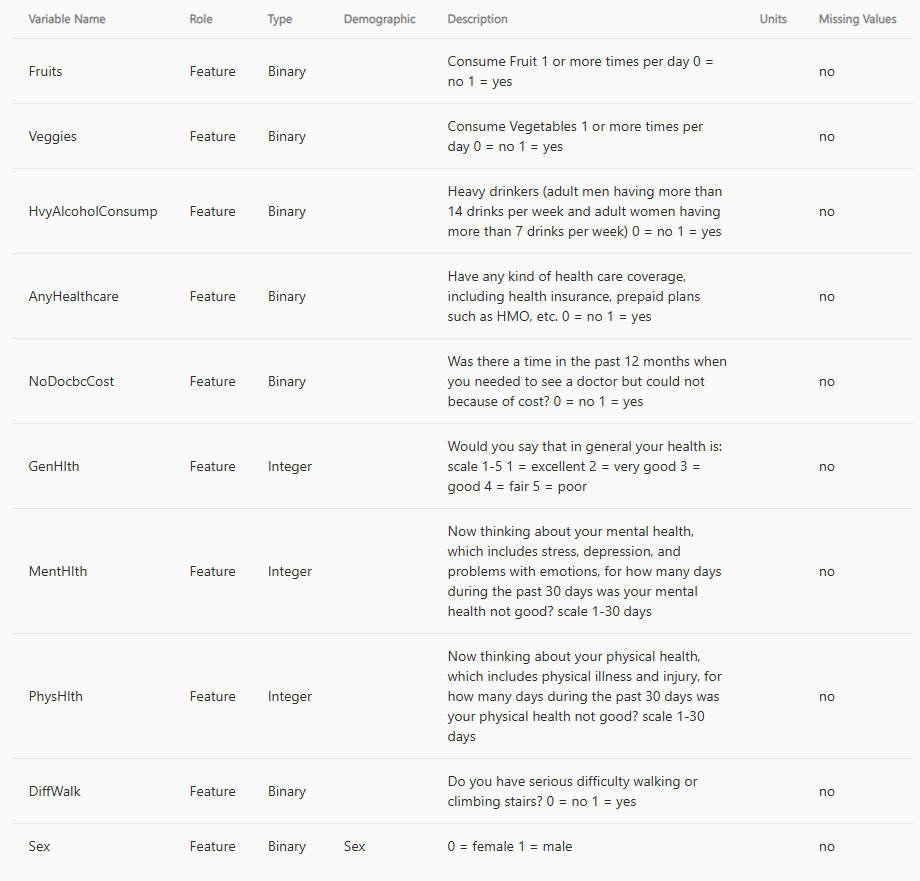

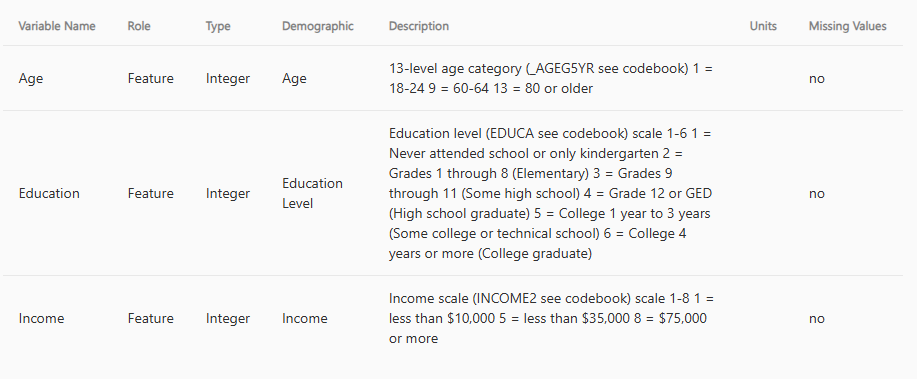

In [5]:
nonb = []
for col in list(df.columns):
  if list(sorted(list(df[col].unique()))) != [0,1]:
    nonb.append(col)
    l = list(df[col].unique())
    l = list(map(int, l))
    print(f"{col} : {l[:5]} ... {l[-6:-1]}") if len(l) > 10 else print(f"{col} : {l}")

In [6]:
def ohe(df, col):
  uni = list(sorted(list(df[col].unique())))
  ohenc = pd.get_dummies(df[col], prefix=f'is_{col}', dtype=int)
  return ohenc

In [7]:
cols = ["Education", "Income", "Age_group_num"]

In [8]:
df = pd.get_dummies(df, columns = cols)

In [9]:
df.to_csv("diabetes_ohe_final.csv")

# БД после ohe

In [10]:
df = pd.read_csv("diabetes_ohe_final.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 47 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Unnamed: 0.1          253680 non-null  int64
 1   Unnamed: 0            253680 non-null  int64
 2   Diabetes_binary       253680 non-null  int64
 3   HighBP                253680 non-null  int64
 4   HighChol              253680 non-null  int64
 5   CholCheck             253680 non-null  int64
 6   BMI                   253680 non-null  int64
 7   Smoker                253680 non-null  int64
 8   Stroke                253680 non-null  int64
 9   HeartDiseaseorAttack  253680 non-null  int64
 10  PhysActivity          253680 non-null  int64
 11  Fruits                253680 non-null  int64
 12  Veggies               253680 non-null  int64
 13  HvyAlcoholConsump     253680 non-null  int64
 14  AnyHealthcare         253680 non-null  int64
 15  NoDocbcCost           253680 non-n

In [12]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [13]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Income_3,Income_4,Income_5,Income_6,Income_7,Income_8,Age_group_num_1,Age_group_num_2,Age_group_num_3,Age_group_num_4
0,0,1,1,1,40,1,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,0,0,0,0,25,1,0,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,0,1,1,1,28,0,0,0,0,1,...,False,False,False,False,False,True,False,False,True,False
3,0,1,0,1,27,0,0,0,1,1,...,False,False,False,True,False,False,False,False,False,True
4,0,1,1,1,24,0,0,0,1,1,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,False,False,False,False,True,False,False,True,False,False
253676,1,1,1,1,18,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
253677,0,0,0,1,28,0,0,0,1,1,...,False,False,False,False,False,False,True,False,False,False
253678,0,1,0,1,23,0,0,0,0,1,...,False,False,False,False,False,False,False,True,False,False


In [14]:
target = "Diabetes_binary"

X = df.drop(columns=[target])
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
undersampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # работает с One-Hot
    ("clf", LogisticRegression(max_iter=500))
])


model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

def predict_diabetes_probability(model, person_dict, reference_df):
    """
    person_dict - данные одного человека в виде словаря
    reference_df - исходный X (нужен, чтобы создать правильный DataFrame)
    """

    person_df = pd.DataFrame([person_dict])

    for col in reference_df.columns:
        if col not in person_df:
            person_df[col] = 0

    person_df = person_df[reference_df.columns]

    ratio = 7069 / 43667

    proba_raw = model.predict_proba(person_df) # [P(0), P(1)]

    P_0_raw = proba_raw[0][0] # Вероятность, что НЕТ диабета
    P_1_raw = proba_raw[0][1] # Вероятность, что ЕСТЬ диабет

    # Применяем рекалибровку, которая будет учитывать неравенство выборок
    P_1_real = (P_1_raw * ratio) / ((P_1_raw * ratio) + P_0_raw)
    return P_1_real

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43667
           1       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736



In [15]:
person = {
    #Уже заполненные значения
    "HighBP": 1,
    "HighChol": 0,
    "CholCheck": 1,
    "BMI": 22,
    "Smoker": 0,
    "Stroke": 0,
    "HeartDiseaseorAttack": 0,
    "PhysActivity": 1,
    "Fruits": 1,
    "Veggies": 0,
    "HvyAlcoholConsump": 0,
    "AnyHealthcare": 1,
    "NoDocbcCost": 0,
    "GenHlth": 3,
    "MentHlth": 5,
    "PhysHlth": 2,
    "DiffWalk": 0,
    "Sex": 1,
    "Age": 5,
    #Удалены Education и Income, так как они представлены one-hot переменными ниже

    #Добавленные значения (int64 и bool)
    "Diabetes_binary": 0, # Нет диабета
    "Obese_flag": 1,      # Флаг ожирения (BMI 28 - может быть ожирение или избыточный вес)
    "LowIncome_flag": 0,  # Не низкий доход (Income 6)
    "HighIncome_flag": 1, # Высокий доход (Income 6)
    "soc_index": 5,       # Произвольный социально-экономический индекс
    "lifestyle_score": 7, # Произвольный показатель образа жизни
    "cardio_index": 3,    # Произвольный кардио-индекс
    "General_index": 6,   # Произвольный общий индекс

    #One-hot переменные для Education (Уровень образования 4 - High School Graduate)
    "Education_1": 0,
    "Education_2": 0,
    "Education_3": 0,
    "Education_4": 1,
    "Education_5": 0,
    "Education_6": 0,

    #One-hot переменные для Income (Уровень дохода 6 - Высокий)
    "Income_1": 0,
    "Income_2": 0,
    "Income_3": 0,
    "Income_4": 0,
    "Income_5": 0,
    "Income_6": 1,
    "Income_7": 0,
    "Income_8": 0,

    #One-hot переменные для Age_group_num (Возрастная группа 5 - Произвольно выбрана)
    "Age_group_num_1": 0,
    "Age_group_num_2": 0,
    "Age_group_num_3": 0,
    "Age_group_num_4": 1,
}

In [16]:
probability = predict_diabetes_probability(model, person, X)
print(f"Вероятность диабета: {probability:.3f}")

Вероятность диабета: 0.687


In [17]:
def explain_risk_factors(model, person_dict, reference_df, top_n=10):

    person_df = pd.DataFrame([person_dict])
    for col in reference_df.columns:
        if col not in person_df:
            person_df[col] = 0
    person_df = person_df[reference_df.columns]

    scaler = model.named_steps['scaler']
    classifier = model.named_steps['clf']

    #Получаем имена признаков и коэффициенты (веса) модели
    feature_names = reference_df.columns
    coefficients = classifier.coef_[0]

    person_scaled_data = scaler.transform(person_df)[0]

    contributions = person_scaled_data * coefficients

    explanation = pd.DataFrame({
        'Feature': feature_names,
        'Original_Value': person_df.iloc[0].values,
        'Contribution': contributions
    })

    #Разделяем на факторы риска и защитные факторы
    #Факторы риска: Contribution > 0 (повышают вероятность диабета)
    #Защитные факторы: Contribution < 0 (понижают вероятность)
    risk_factors = explanation[explanation['Contribution'] > 0].sort_values(by='Contribution', ascending=False)
    protective_factors = explanation[explanation['Contribution'] < 0].sort_values(by='Contribution', ascending=True)

    return risk_factors, protective_factors

risk, protective = explain_risk_factors(model, person, X)

print(f"--- АНАЛИЗ ДЛЯ ПАЦИЕНТА ---")
print(f"Всего признаков с положительным вкладом (Риск): {len(risk)}")
print(f"Всего признаков с отрицательным вкладом (Защита): {len(protective)}\n")

print(f"ТОП-5 ФАКТОРОВ РИСКА (повышают шанс диабета):")
# Выводим Feature, Original_Value и Contribution
print(risk[['Feature', 'Original_Value', 'Contribution']].head(5).to_string(index=False))

print(f"\nТОП-5 ЗАЩИТНЫХ ФАКТОРОВ (снижают шанс диабета):")
print(protective[['Feature', 'Original_Value', 'Contribution']].head(5).to_string(index=False))

--- АНАЛИЗ ДЛЯ ПАЦИЕНТА ---
Всего признаков с положительным вкладом (Риск): 11
Всего признаков с отрицательным вкладом (Защита): 8

ТОП-5 ФАКТОРОВ РИСКА (повышают шанс диабета):
   Feature  Original_Value  Contribution
   GenHlth               3      1.748408
 CholCheck               1      1.348459
       BMI              22      1.102745
       Age               5      0.421658
Obese_flag               1      0.375240

ТОП-5 ЗАЩИТНЫХ ФАКТОРОВ (снижают шанс диабета):
      Feature  Original_Value  Contribution
 cardio_index               3     -1.231650
General_index               6     -0.693794
    soc_index               5     -0.587054
  Education_4               1     -0.379168
     Income_6               1     -0.144058


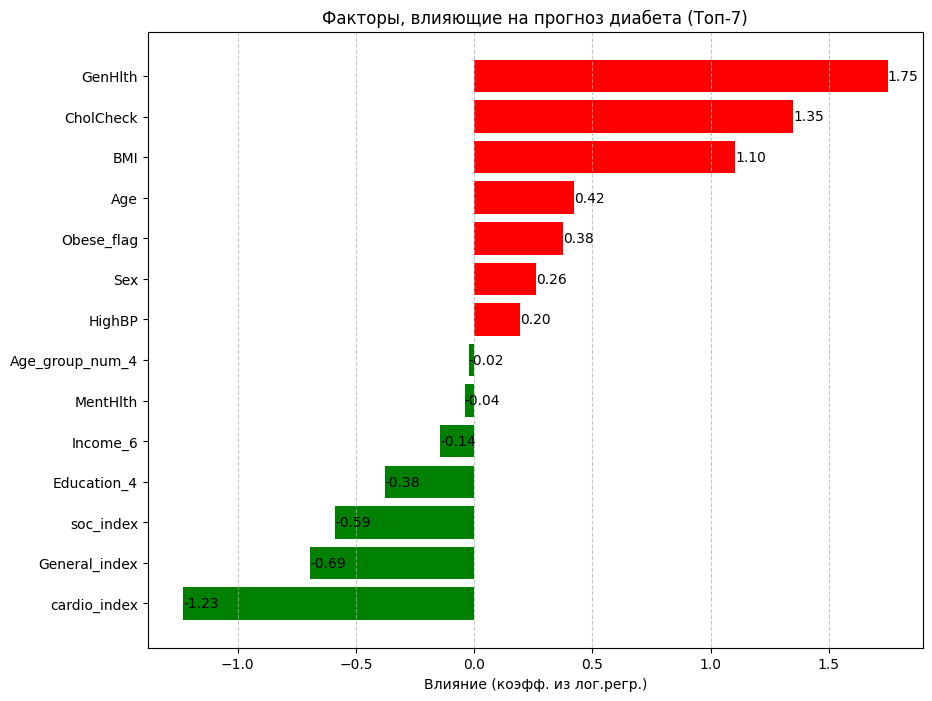

In [18]:
def plot_factors(risk, protective, n=7):
    """
    Рисует график топ-N факторов риска и защиты.
    """
    # Берем топ-N факторов с обеих сторон
    top_risks = risk.head(n).copy()
    top_protective = protective.head(n).copy()

    combined = pd.concat([top_risks, top_protective]).sort_values(by='Contribution')

    colors = ['green' if x < 0 else 'red' for x in combined['Contribution']]

    plt.figure(figsize=(10, 8))
    plt.barh(combined['Feature'], combined['Contribution'], color=colors)
    plt.xlabel("Влияние (коэфф. из лог.регр.)")
    plt.title(f"Факторы, влияющие на прогноз диабета (Топ-{n})")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    for index, value in enumerate(combined['Contribution']):
        plt.text(value, index, f"{value:.2f}", va='center')

    plt.show()

plot_factors(risk, protective)